# Supplement: Level-Log Scenarios

*This script is only to be run after **1_Project-Master-File.ipynb** has been run as we read off the cleaned csv files which we save down in that notebook.*

### Contents:
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
    - [Linear Regression](#Linear-Regression)
    - [Ridge Regression](#Ridge-Regression)
    - [Lasso Regression](#Lasso-Regression)

#### Import Packages and Data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import patsy

from sklearn.linear_model    import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing   import StandardScaler, PolynomialFeatures
from sklearn.dummy           import DummyRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Preprocessing

In [2]:
# Read master TRAIN data with all original features and our engineered features
master_train_data = pd.read_csv("./datasets/backup_files/train_master_model_data.csv") 
print("Master Train Data has",master_train_data.shape[1],"columns")

# Read master TEST data with all original features and our engineered features
master_test_data = pd.read_csv("./datasets/backup_files/test_master_model_data.csv") 
print("Master Test Data has",master_test_data.shape[1],"columns")

Master Train Data has 518 columns
Master Test Data has 518 columns


In [3]:
# Numeric columns
numeric_cols = ['Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Utilities',
                'Land Slope', 'Overall Qual', 'Overall Cond', 'Mas Vnr Area',
                'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
                'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
                'Bsmt Unf SF', 'Total Bsmt SF', 'Heating QC', '1st Flr SF',
                '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
                'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
                'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
                'Fireplaces', 'Fireplace Qu', 'Garage Cars', 'Garage Area',
                'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF',
                'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
                'Pool Area', 'Pool QC', 'Misc Val']

In [4]:
# Extract features we've decided to use
features = list(master_train_data.drop('SalePrice',axis=1).columns)
X_top_train = master_train_data[features]
y = master_train_data['SalePrice']

In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_top_train, y, random_state = 42)

# Scale numerics (but not dummies)
ss = StandardScaler()
X_train.loc[:,numeric_cols] = ss.fit_transform(X_train[numeric_cols])
X_test.loc[:,numeric_cols] = ss.transform(X_test[numeric_cols])
master_test_data.loc[:,numeric_cols] = ss.transform(master_test_data[numeric_cols])

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Adiwid\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Adiwid\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
C:

## Modeling

*Before we go ahead, it will be helpful to have some helper functions handy*

In [6]:
# Write function to automate graphing process
def plot_predictions(model_name, y_train_pred, y_test_pred, y_train_actual, y_test_actual):
    plt.scatter(y_train_pred, y_train_actual, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_actual, c = "lightgreen", marker = "s", label = "Testing data")
    plt.title(model_name+"Regression")
    plt.xlabel("$\hat{y}$ = Predicted SalePrice")
    plt.ylabel("$y$ = Actual SalePrice")
    plt.legend(loc = "upper left")
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()

#### Linear Regression

In [7]:
# Instantiate and fit
lr = LinearRegression()
ols = lr.fit(X_train, y_train)

# Predict y_hat
yhat_train_OLS = ols.predict(X_train)
yhat_test_OLS = ols.predict(X_test)

In [8]:
# Score it
ols_cvs = cross_val_score(ols, X_train, y_train, cv=5).mean()
print("K=5 Fold Cross Validation Score is:", np.round(ols_cvs,3)) 
print("Training Set R^2 Score is:", np.round(ols.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(ols.score(X_test, y_test),3))

K=5 Fold Cross Validation Score is: 0.838
Training Set R^2 Score is: 0.939
Testing Set R^2 Score is: 0.878


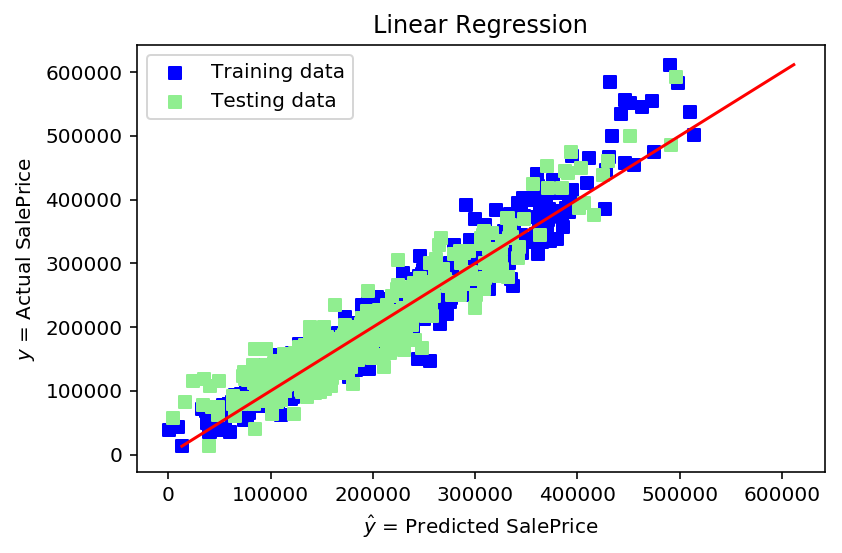

In [9]:
# Plot it
plot_predictions(model_name = "Linear ",
                 y_train_pred = yhat_train_OLS,
                 y_test_pred = yhat_test_OLS,
                 y_train_actual = y_train,
                 y_test_actual = y_test)

#### Ridge Regression

In [10]:
# Instantiate and fit, while optimizing alpha
parameter_grid = {'alpha': [0.01, 0.1, 1, 5, 10, 25, 50, 100]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=parameter_grid, scoring='r2')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']

# Re-optimize alpha based on another grid around this optimal alpha
parameter_grid = {'alpha': [x/100. * alpha for x in range(50, 150, 5)]}
ridge = GridSearchCV(Ridge(), cv=5, param_grid=parameter_grid, scoring='r2')
ridge.fit(X_train, y_train)
alpha = ridge.best_params_['alpha']
ridge = ridge.best_estimator_
print("Optimal Alpha:",alpha)

Optimal Alpha: 14.0


In [11]:
# Predict y_hat
yhat_train_ridge = ridge.predict(X_train)
yhat_test_ridge = ridge.predict(X_test)

In [12]:
%%time
# Score it
ridge_cvs = cross_val_score(ridge, X_train, y_train, cv=5).mean()
print("K=5 Fold Cross Validation Score is:", np.round(ridge_cvs,3)) 
print("Training Set R^2 Score is:", np.round(ridge.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(ridge.score(X_test, y_test),3))

K=5 Fold Cross Validation Score is: 0.891
Training Set R^2 Score is: 0.921
Testing Set R^2 Score is: 0.911
Wall time: 266 ms


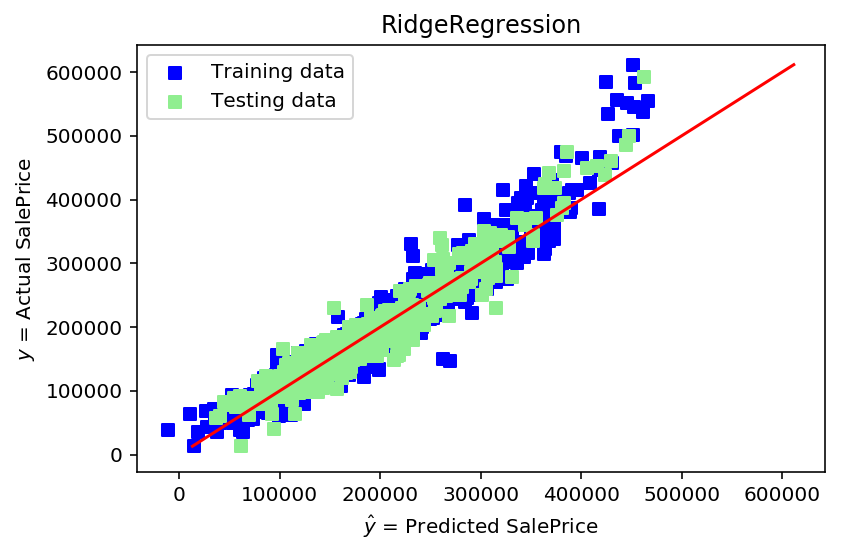

In [13]:
# Plot it
plot_predictions(model_name = "Ridge",
                 y_train_pred = yhat_train_ridge,
                 y_test_pred = yhat_test_ridge,
                 y_train_actual = y_train,
                 y_test_actual = y_test)

In [14]:
# Output csv in Kaggle-Form
X_holdout = master_test_data[features]
X_holdout['SalePrice'] = ridge.predict(X_holdout)
X_holdout.drop(features, axis=1, inplace=True)
X_holdout.to_csv("./kaggle_submissions/ridge_model_Dummies_LevLog_REVAMP.csv")

#### Lasso Regression

In [15]:
# Instantiate and fit, while optimize alpha
parameter_grid = {'alpha': list(np.arange(0.1, 1.5, 0.1)),
                  'tol': [0.001]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=parameter_grid, scoring='r2')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
Lasso()

# Re-optimize alpha
parameter_grid = {'alpha': [(x/100)*alpha for x in range(50, 150, 5)],
                  'tol': [0.001]}
lasso = GridSearchCV(Lasso(), cv=5, param_grid=parameter_grid, scoring='r2')
lasso.fit(X_train, y_train)
alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

In [16]:
# Predict y_hat
yhat_train_lasso = lasso.predict(X_train)
yhat_test_lasso = lasso.predict(X_test)

In [17]:
# Score it
lasso_cvs = cross_val_score(lasso, X_train, y_train, cv=5).mean()
print("K=5 Fold Cross Validation Score is:", np.round(lasso_cvs,3)) 
print("Training Set R^2 Score is:", np.round(lasso.score(X_train, y_train),3))
print("Testing Set R^2 Score is:", np.round(lasso.score(X_test, y_test),3))

C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to in

K=5 Fold Cross Validation Score is: 0.858
Training Set R^2 Score is: 0.938
Testing Set R^2 Score is: 0.896


C:\Users\Adiwid\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


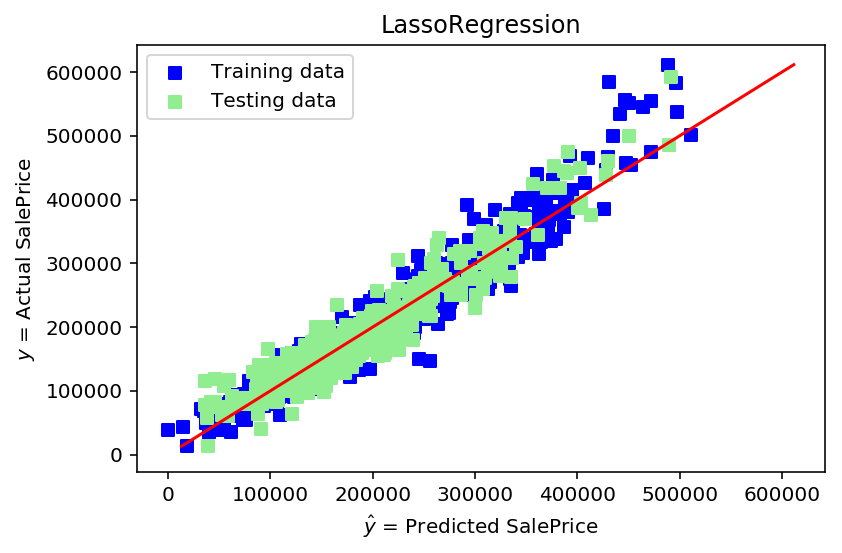

In [18]:
# Plot it
plot_predictions(model_name = "Lasso",
                 y_train_pred = yhat_train_lasso,
                 y_test_pred = yhat_test_lasso,
                 y_train_actual = y_train,
                 y_test_actual = y_test)